# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$
* $R$ : reward, $P$ : punishment, $T$ : temptation, $S$ : sucker

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


# Solutions of the Assignments

### Initial setup

In [331]:
# Importing all necessary modules
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Set the Payoff matrix
M = np.array([[3, 0], 
              [5, 2]])

### Auxiliary functions and classes

In this section we define the core classes and functionallities needed to solve the given assignments.

In [332]:
# Auxiliary functions
def generate_matchups(people):
    '''
    Parms:
        people: list
        list of people that want to participate in a tournament
    ouput:
        Returns a list of tuples, combinations for each match.
    '''
    matchups = list(combinations(people, 2))
    return matchups

In [333]:
# Main class for the players
class Player():
    def __init__(self, strategy, initial_action, name):
        '''
        Params:
            strategy : dict
                Dictionary with two keys which represent
                the previous action of the opponent. 0 for
                cooperation and 1 for defection. 
                The corresponding entries are a number 
                between 0 and 1, representing the probability
                that the player cooperates given the previous
                move of the opponent.
    
            initial_action : float
                A number between 0 and 1, representing the 
                probability that the player cooperates in
                the first turn.
                
            name : str
                Name of the player.
        '''
        self.strategy = strategy
        self.initial_action = initial_action
        self.name = name
        
    def GetInitialAction(self, r):
        '''
        Params:
            r : float
                Randomly drawn number from 0 to 1.
        
        Ouput:
            Returns a 0 if r <= self.initial_action 
            and 0 otherwise.
        '''
        return 1 - int(r <= self.initial_action)
            
    def GetNextAction(self, prev_opponent_action, r):
        '''
        Params:
            prev_opponent_action : int
                Either a 0 (cooperation) or a 1 (defection)
                corresponding to the previous action of the
                player.
                
            r : float
                Randomly drawn number from 0 to 1.
        
        Ouput:
            Returns a 0 if r <= P(action) and 1 otherwise,
            where P(action) is the probability of cooperating
            given the previous action of the oponent.
        '''
        action_prob = self.strategy[prev_opponent_action]
        next_move = 1 - int(r <= action_prob)
        return next_move

In [334]:
# Main class for a single game
class Game():
    def __init__(self, M, player_1, player_2, N, seed=42):
        '''
        Params:
            M : numpy array
                Array of shape (2, 2) containing the
                payoff matrix, which is used to 
                calculate the reward each player 
                receives after a single iteration.
                
            player_1, player_2 : Player
                The two Player instances that will
                participate in the game.
                
            N : int
                Number of iterations of the game.
                
            seed : int (optional)
                Seed for the random number generator. 
                Default value is 42.
        '''
        self.M = M 
        self.player_1 = player_1
        self.player_2 = player_2
        self.N = N
        
        # Some additional attributes:
        # Action history for both players
        self.history_1 = []
        self.history_2 = []
        # Reward history for both players
        self.rewards_1 = []
        self.rewards_2 = []
        
        # Initialize random seed
        np.random.seed(seed)
       
    def GetReward(self, action_1, action_2):
        '''
        Params:
            action_1, action_2 : int
                Actions from players 1 and 2, respectively, 
                where 0 corresponds to cooperation and 1 to
                defection.
        
        Output:
            Returns a tuple of two values containing the
            reward estimated for players 1 and 2, respectively.
        '''
        reward_1 = self.M[action_1, action_2]
        reward_2 = self.M[action_2, action_1]
        return reward_1, reward_2
    
    
    def SaveHistory(self, action_1, action_2, reward_1, reward_2):
        '''
        Params:
            action_1, action_2 : int
                Latest action of players 1 and 2 respectively.
            
            reward_1, reward_2 : int
                Latest reward of players 1 and 2 respectively.
                
        Output:
            Saves the latest actions and rewards to their 
            corresponding history.
        '''
        # Save actions
        self.history_1.append(action_1)
        self.history_2.append(action_2)
        
        # Save rewards
        self.rewards_1.append(reward_1)
        self.rewards_2.append(reward_2)
         
    def InitialIteration(self, r_1, r_2):
        '''
        Params:
            r_1, r_2 : float
                Randomly drawn numbers from 0 to 1.
            
        Output:
            Performs the initial iteration of the game.
        '''
        # Get initial actions 
        action_1 = self.player_1.GetInitialAction(r_1)
        action_2 = self.player_2.GetInitialAction(r_2)
        
        # Get initial rewards
        reward_1, reward_2 = self.GetReward(action_1, action_2)
        
        # Save actions and rewards
        self.SaveHistory(action_1, action_2, reward_1, reward_2)
    
    def SingleIteration(self, r_1, r_2):
        '''
        Params:
            r_1, r_2 : float
                Randomly drawn numbers from 0 to 1.
            
        Output:
            Performs a new iteration of the game. This
            method must be called after the initial
            iteration of the game.
        '''
        # Get previous action from both players
        prev_1 = self.history_1[-1]
        prev_2 = self.history_2[-1]
        
        # Get new actions
        action_1 = self.player_1.GetNextAction(prev_2, r_1)
        action_2 = self.player_2.GetNextAction(prev_1, r_2)
        
        # Get rewards
        reward_1, reward_2 = self.GetReward(action_1, action_2)
        
        # Save actions and rewards
        self.SaveHistory(action_1, action_2, reward_1, reward_2)
        
    def Play(self):
        '''
        Plays the entire game.
        
        Output:
            Returns a dictionary with the specifications
            and results of the game.
        '''
        # Generate random numbers for both players
        r_1 = np.random.uniform(size=self.N)
        r_2 = np.random.uniform(size=self.N)
        
        # Perform initial iteration
        self.InitialIteration(r_1[0], r_2[0])
        
        # Perform remaining iterations
        for i in range(self.N - 1):
            self.SingleIteration(r_1[i+1], r_2[i+1])
        
        # Build and return final dictionary
        final_dict = {'game_title': self.player_1.name + ' VS ' + self.player_2.name,
                      'actions_player_' + self.player_1.name : self.history_1.copy(),
                      'rewards_player_' + self.player_1.name : self.rewards_1.copy(),
                      'total_reward_player_1' : np.sum(self.rewards_1),
                      'actions_player_' + self.player_2.name : self.history_2.copy(),
                      'rewards_player_' + self.player_2.name : self.rewards_2.copy(), 
                      'total_reward_player_2' : np.sum(self.rewards_2)}

        return final_dict

### Defining players

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

In [369]:
Nice_guy = Player({0:1, 1:1}, 1, 'Nice_guy')
Bad_guy = Player({0:0, 1:0}, 0, 'Bad_guy')
Mainly_nice = Player({0:0.7, 1:0.7}, 0.7, 'Mainly_nice') # k = 30
Mainly_bad = Player({0:0.3, 1:0.3}, 0.3, 'Mainly_bad') # k = 70
tit_4_tat = Player({0:1, 1:0}, 1, 'tit_4_tat')

### Let's hold 1 vs 1 games

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

#### Nice Guy VS Bad Guy
for example let's see the result of 20 rounds game between nice guy and bad guy

In [29]:
play = Game(M, Nice_guy, Bad_guy, 20)
play_result = play.Play()

print('0 : cooperation and 1 : defection\n')
print(play_result['game_title'], '\n')
print('Nice guy actions:', play_result['actions_player_Nice_guy'])
print('Bad guy actions: ', play_result['actions_player_Bad_guy'])
print('Nice guy rewards:', play_result['rewards_player_Nice_guy'])
print('Bad guy actions: ', play_result['rewards_player_Bad_guy'])
print('Nice guy total score:', play_result['total_reward_player_1'])
print('Bad guy total score: ', play_result['total_reward_player_2'])

0 : cooperation and 1 : defection

Nice_guy VS Bad_guy 

Nice guy actions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bad guy actions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Nice guy rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bad guy actions:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Nice guy total score: 0
Bad guy total score:  100


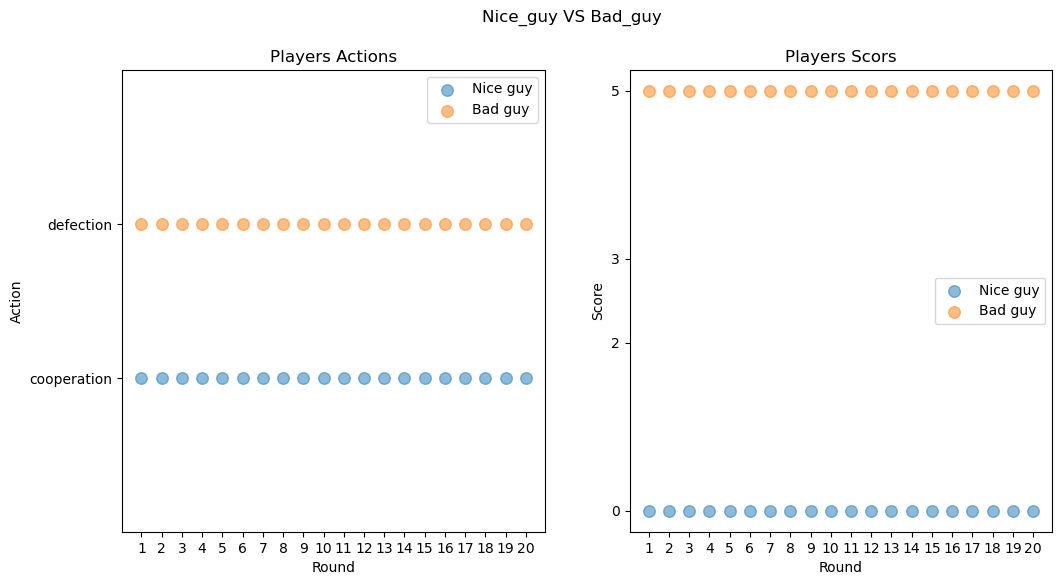

In [30]:
time_evolution = np.arange(1, 21)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x=time_evolution, y=play_result['actions_player_Nice_guy'],
            s=70, marker='o', alpha=0.5, label='Nice guy')
plt.scatter(x=time_evolution, y=play_result['actions_player_Bad_guy'],
            s=70, marker='o', alpha=0.5, label='Bad guy')

plt.title('Players Actions')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Action')
plt.xticks(time_evolution)
plt.yticks([0, 1], ['cooperation', 'defection'])
plt.ylim(-1, 2)

plt.subplot(1, 2, 2)
plt.scatter(x=time_evolution, y=play_result['rewards_player_Nice_guy'], 
            s=70, marker='o', alpha=0.5, label='Nice guy')
plt.scatter(x=time_evolution, y=play_result['rewards_player_Bad_guy'],
            s=70, marker='o', alpha=0.5, label='Bad guy')

plt.title('Players Scors')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.yticks(M.flatten())

plt.suptitle(play_result['game_title'])
plt.show()

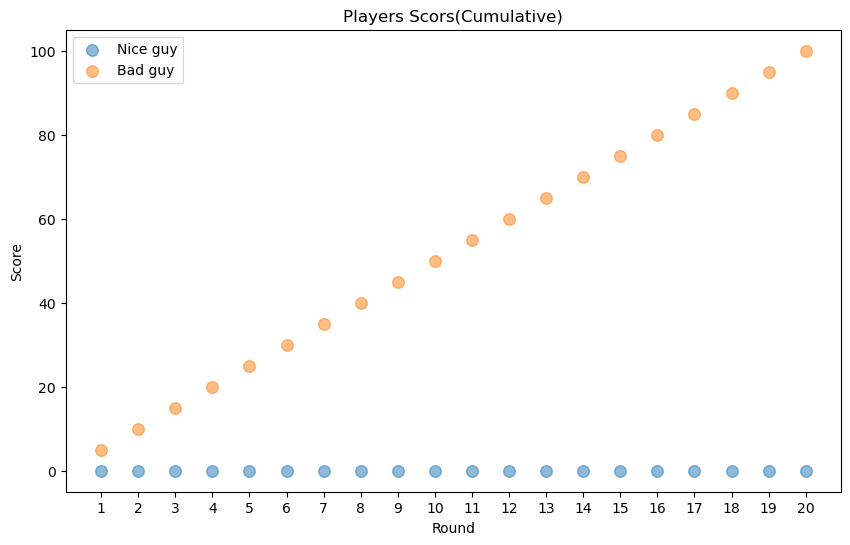

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Nice_guy']), 
            s=70, marker='o', alpha=0.5, label='Nice guy')
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Bad_guy']),
            s=70, marker='o', alpha=0.5, label='Bad guy')

plt.title('Players Scors(Cumulative)')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.show()

#### Mainly Nice Guy VS Mainly Bad Guy
for example let's see the result of 20 rounds game between mainly nice guy and mainly bad guy

In [32]:
play = Game(M, Mainly_nice, Mainly_bad, 20)
play_result = play.Play()

print('0 : cooperation and 1 : defection\n')
print(play_result['game_title'], '\n')
print('Mainly nice actions:', play_result['actions_player_Mainly_nice'])
print('Mainly bad actions: ', play_result['actions_player_Mainly_bad'])
print('Mainly nice rewards:', play_result['rewards_player_Mainly_nice'])
print('Mainly bad actions: ', play_result['rewards_player_Mainly_bad'])
print('Mainly nice total score:', play_result['total_reward_player_1'])
print('Mainly bad total score: ', play_result['total_reward_player_2'])

0 : cooperation and 1 : defection

Mainly_nice VS Mainly_bad 

Mainly nice actions: [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Mainly bad actions:  [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Mainly nice rewards: [0, 5, 5, 0, 0, 0, 3, 2, 0, 5, 0, 5, 5, 0, 0, 0, 0, 3, 0, 0]
Mainly bad actions:  [5, 0, 0, 5, 5, 5, 3, 2, 5, 0, 5, 0, 0, 5, 5, 5, 5, 3, 5, 5]
Mainly nice total score: 33
Mainly bad total score:  68


let's take look to the time evolution. what's going on in each round?

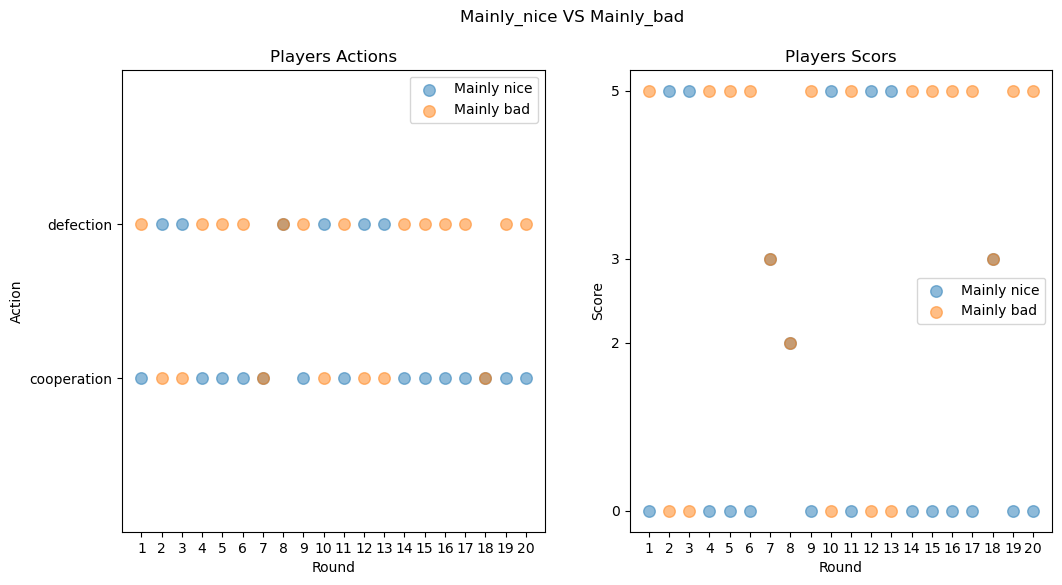

In [33]:
time_evolution = np.arange(1, 21)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x=time_evolution, y=play_result['actions_player_Mainly_nice'],
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=play_result['actions_player_Mainly_bad'],
            s=70, marker='o', alpha=0.5, label='Mainly bad')

plt.title('Players Actions')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Action')
plt.xticks(time_evolution)
plt.yticks([0, 1], ['cooperation', 'defection'])
plt.ylim(-1, 2)

plt.subplot(1, 2, 2)
plt.scatter(x=time_evolution, y=play_result['rewards_player_Mainly_nice'], 
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=play_result['rewards_player_Mainly_bad'],
            s=70, marker='o', alpha=0.5, label='Mainly bad')

plt.title('Players Scors')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.yticks(M.flatten())

plt.suptitle(play_result['game_title'])
plt.show()

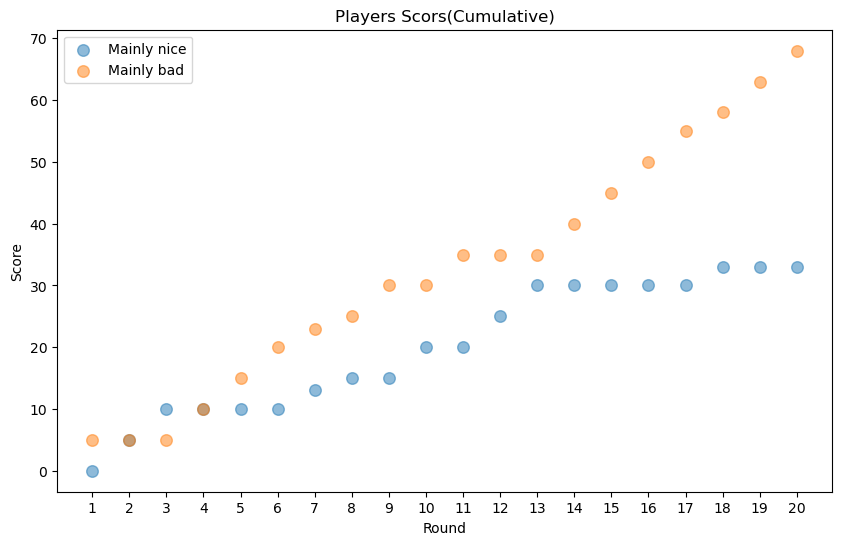

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_nice']), 
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_bad']),
            s=70, marker='o', alpha=0.5, label='Mainly bad')

plt.title('Players Scors(Cumulative)')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.show()

Let's increse number of rounds

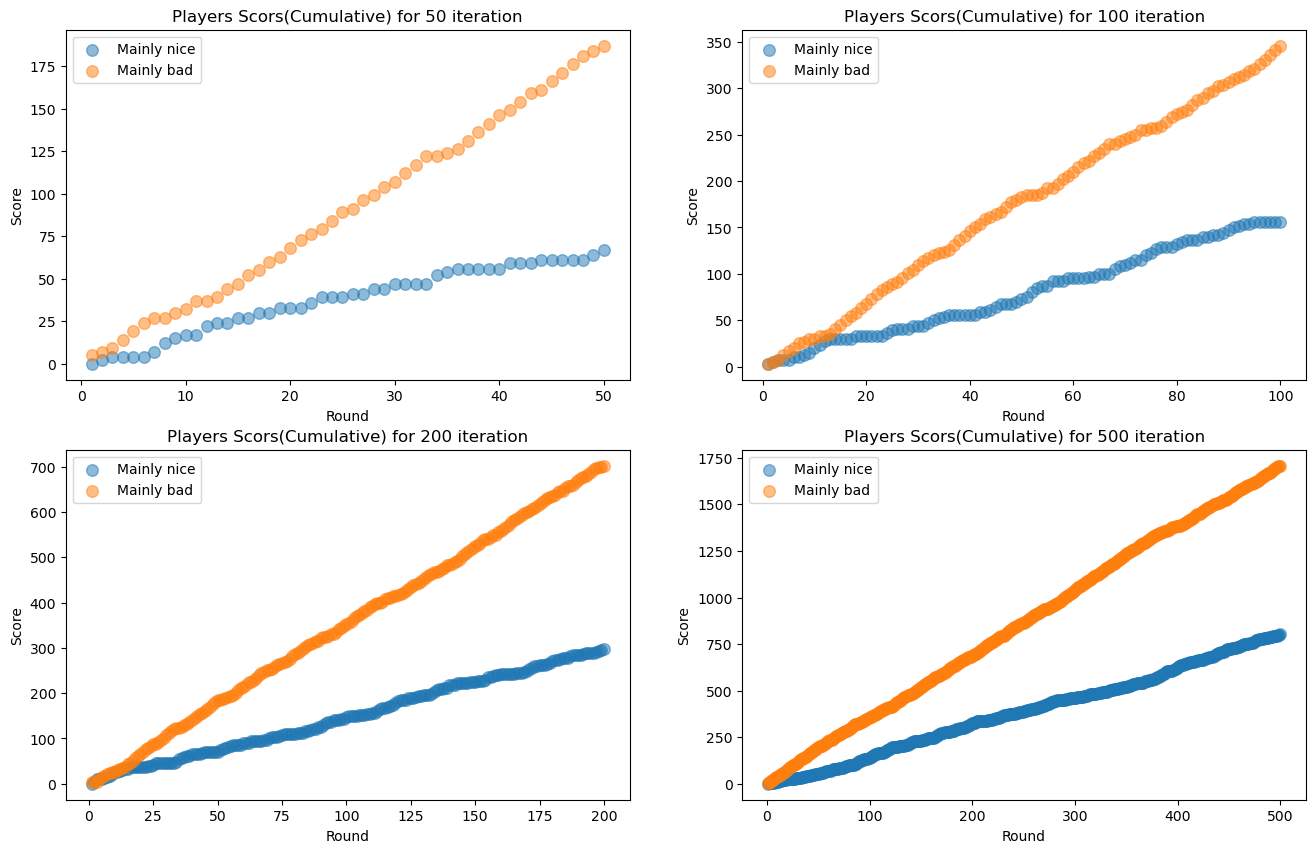

In [35]:
n_list = [50, 100, 200, 500]
plt.figure(figsize=(16, 10))

for i in range(4):
    play = Game(M, Mainly_nice, Mainly_bad, n_list[i])
    play_result = play.Play()
    time_evolution = np.arange(1, n_list[i]+1)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_nice']), 
                s=70, marker='o', alpha=0.5, label='Mainly nice')
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_bad']),
                s=70, marker='o', alpha=0.5, label='Mainly bad')

    plt.title('Players Scors(Cumulative) for %i iteration' %n_list[i])
    plt.legend()

    plt.xlabel('Round')
    plt.ylabel('Score')

plt.show()

#### Mainly Nice Guy VS Tit for Tat

In [36]:
play = Game(M, Mainly_nice, tit_4_tat, 20)
play_result = play.Play()

print('0 : cooperation and 1 : defection\n')
print(play_result['game_title'], '\n')
print('Mainly nice actions:', play_result['actions_player_Mainly_nice'])
print('Tit 4 Tat actions: ', play_result['actions_player_tit_4_tat'])
print('Mainly nice rewards:', play_result['rewards_player_Mainly_nice'])
print('Tit 4 Tat actions: ', play_result['rewards_player_tit_4_tat'])
print('Mainly nice total score:', play_result['total_reward_player_1'])
print('Tit 4 Tat actions total score: ', play_result['total_reward_player_2'])

0 : cooperation and 1 : defection

Mainly_nice VS tit_4_tat 

Mainly nice actions: [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Tit 4 Tat actions:  [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Mainly nice rewards: [3, 5, 2, 0, 3, 3, 3, 5, 0, 5, 0, 5, 2, 0, 3, 3, 3, 3, 3, 3]
Tit 4 Tat actions:  [3, 0, 2, 5, 3, 3, 3, 0, 5, 0, 5, 0, 2, 5, 3, 3, 3, 3, 3, 3]
Mainly nice total score: 54
Tit 4 Tat actions total score:  54


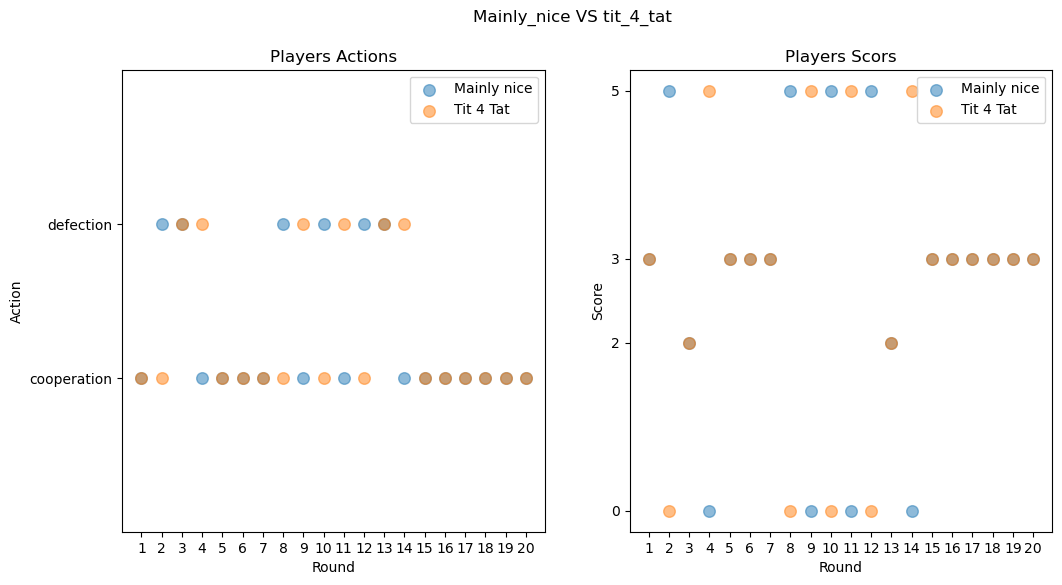

In [37]:
time_evolution = np.arange(1, 21)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x=time_evolution, y=play_result['actions_player_Mainly_nice'], 
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=play_result['actions_player_tit_4_tat'], 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Actions')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Action')
plt.xticks(time_evolution)
plt.yticks([0, 1], ['cooperation', 'defection'])
plt.ylim(-1, 2)

plt.subplot(1, 2, 2)
plt.scatter(x=time_evolution, y=play_result['rewards_player_Mainly_nice'], 
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=play_result['rewards_player_tit_4_tat'], 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Scors')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.yticks(M.flatten())

plt.suptitle(play_result['game_title'])
plt.show()

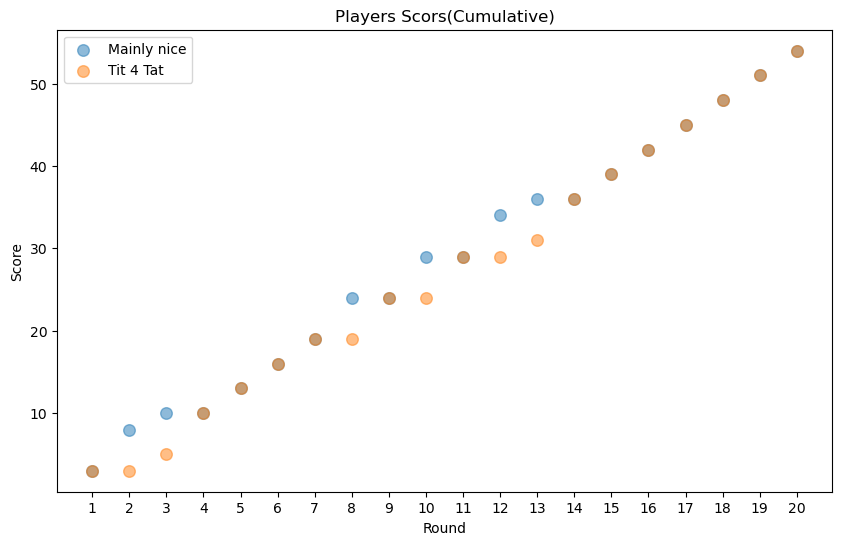

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_nice']), 
            s=70, marker='o', alpha=0.5, label='Mainly nice')
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_tit_4_tat']), 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Scors(Cumulative)')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.show()

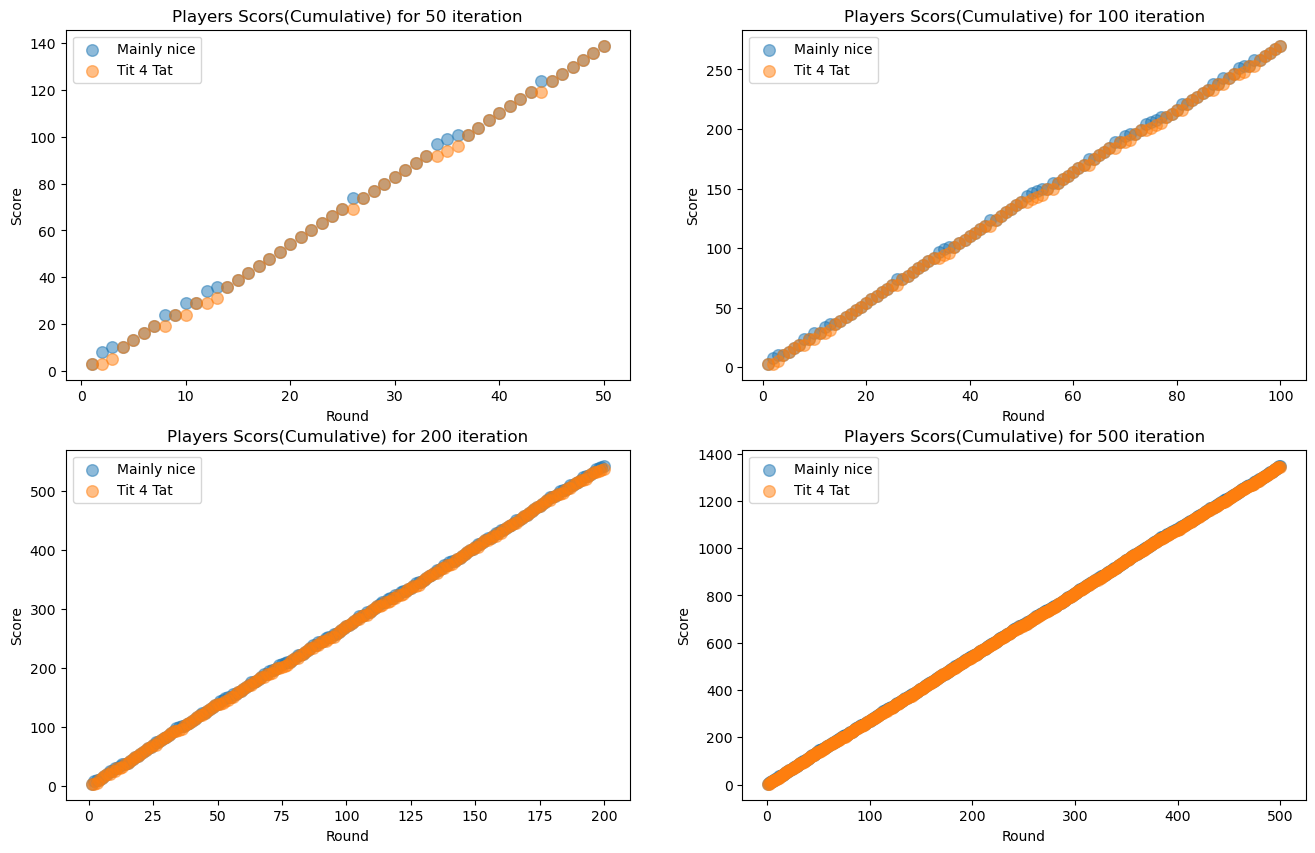

In [39]:
n_list = [50, 100, 200, 500]
plt.figure(figsize=(16, 10))

for i in range(4):
    play = Game(M, Mainly_nice, tit_4_tat, n_list[i])
    play_result = play.Play()
    time_evolution = np.arange(1, n_list[i]+1)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_nice']), 
                s=70, marker='o', alpha=0.5, label='Mainly nice')
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_tit_4_tat']), 
                s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

    plt.title('Players Scors(Cumulative) for %i iteration' %n_list[i])
    plt.legend()

    plt.xlabel('Round')
    plt.ylabel('Score')

plt.show()

#### Mainly Bad Guy VS Tit for Tat

In [40]:
play = Game(M, Mainly_bad, tit_4_tat, 20)
play_result = play.Play()

print('0 : cooperation and 1 : defection\n')
print(play_result['game_title'], '\n')
print('Mainly bad actions:', play_result['actions_player_Mainly_bad'])
print('Tit 4 Tat actions: ', play_result['actions_player_tit_4_tat'])
print('Mainly bad rewards:', play_result['rewards_player_Mainly_bad'])
print('Tit 4 Tat actions: ', play_result['rewards_player_tit_4_tat'])
print('Mainly bad total score:', play_result['total_reward_player_1'])
print('Tit 4 Tat actions total score: ', play_result['total_reward_player_2'])

0 : cooperation and 1 : defection

Mainly_bad VS tit_4_tat 

Mainly bad actions: [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Tit 4 Tat actions:  [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
Mainly bad rewards: [5, 2, 2, 2, 0, 3, 3, 5, 2, 2, 0, 5, 2, 0, 3, 3, 5, 2, 2, 0]
Tit 4 Tat actions:  [0, 2, 2, 2, 5, 3, 3, 0, 2, 2, 5, 0, 2, 5, 3, 3, 0, 2, 2, 5]
Mainly bad total score: 48
Tit 4 Tat actions total score:  48


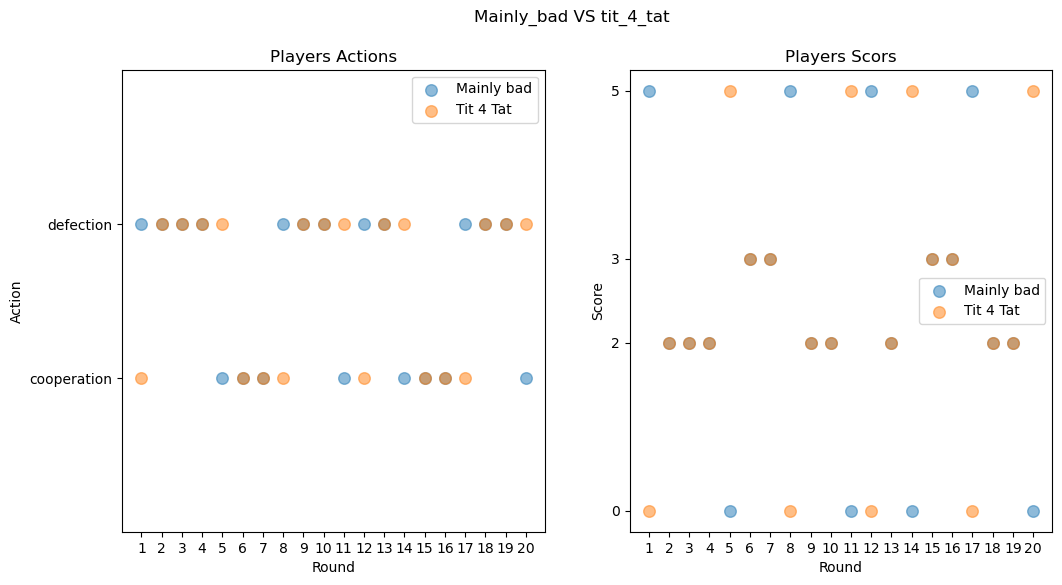

In [41]:
time_evolution = np.arange(1, 21)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x=time_evolution, y=play_result['actions_player_Mainly_bad'], 
            s=70, marker='o', alpha=0.5, label='Mainly bad')
plt.scatter(x=time_evolution, y=play_result['actions_player_tit_4_tat'], 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Actions')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Action')
plt.xticks(time_evolution)
plt.yticks([0, 1], ['cooperation', 'defection'])
plt.ylim(-1, 2)

plt.subplot(1, 2, 2)
plt.scatter(x=time_evolution, y=play_result['rewards_player_Mainly_bad'], 
            s=70, marker='o', alpha=0.5, label='Mainly bad')
plt.scatter(x=time_evolution, y=play_result['rewards_player_tit_4_tat'], 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Scors')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.yticks(M.flatten())

plt.suptitle(play_result['game_title'])
plt.show()

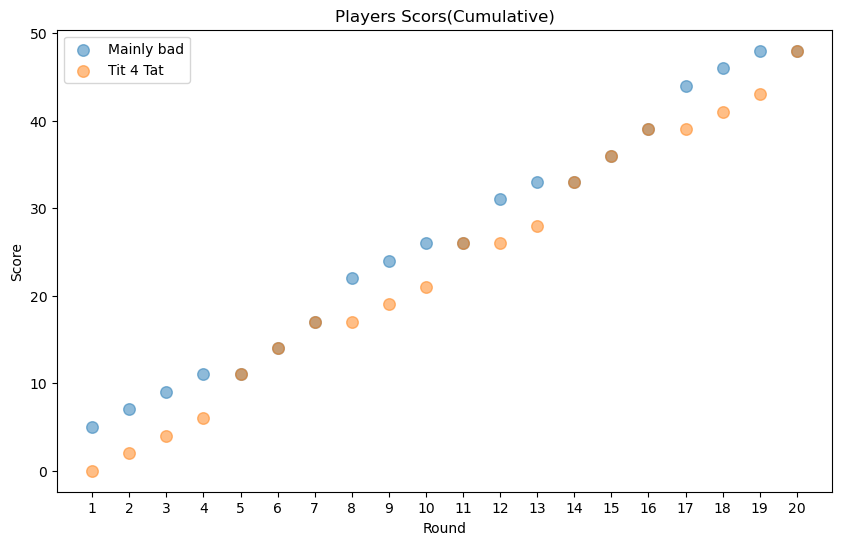

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_bad']), 
            s=70, marker='o', alpha=0.5, label='Mainly bad')
plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_tit_4_tat']), 
            s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

plt.title('Players Scors(Cumulative)')
plt.legend()

plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(time_evolution)
plt.show()

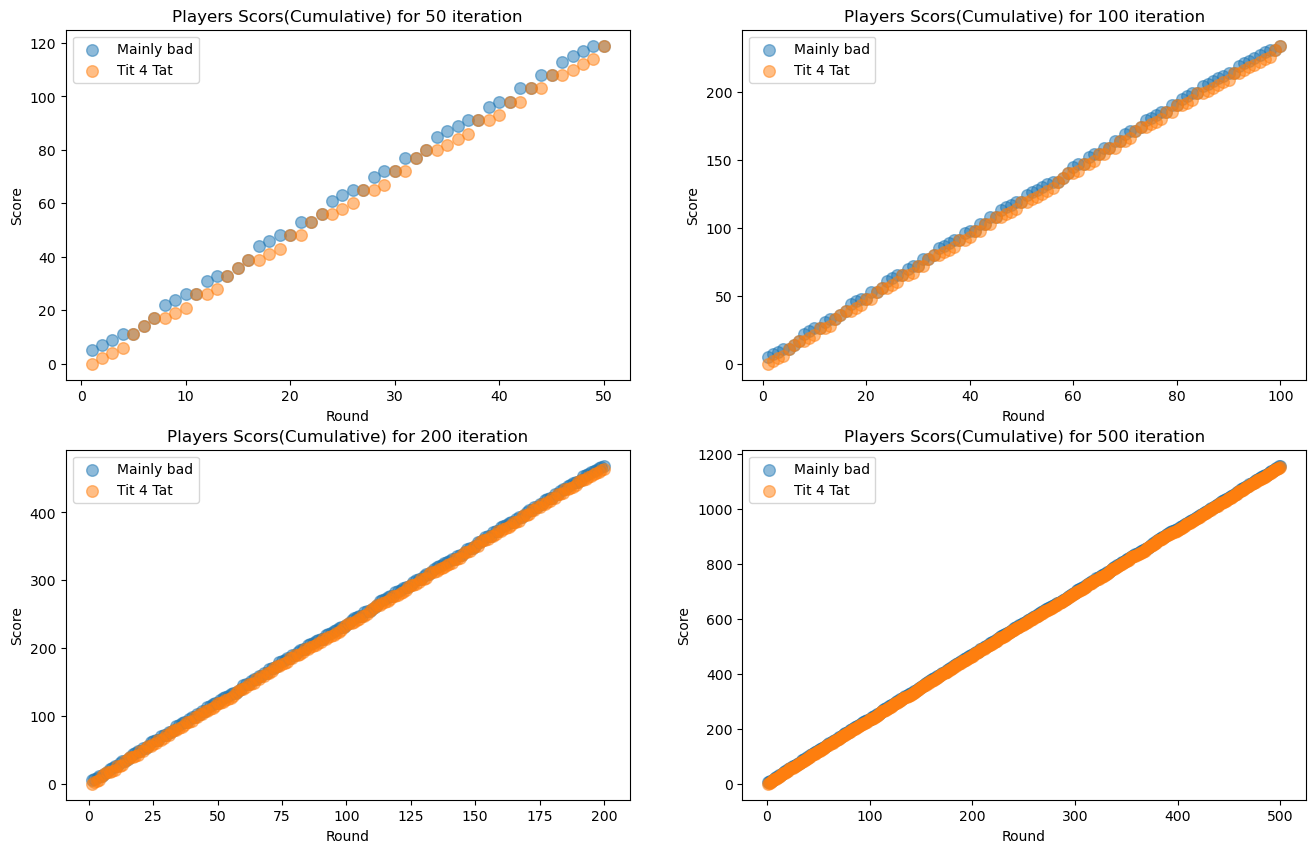

In [43]:
n_list = [50, 100, 200, 500]
plt.figure(figsize=(16, 10))

for i in range(4):
    play = Game(M, Mainly_bad, tit_4_tat, n_list[i])
    play_result = play.Play()
    time_evolution = np.arange(1, n_list[i]+1)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_Mainly_bad']), 
                s=70, marker='o', alpha=0.5, label='Mainly bad')
    plt.scatter(x=time_evolution, y=np.cumsum(play_result['rewards_player_tit_4_tat']), 
                s=70, marker='o', alpha=0.5, label='Tit 4 Tat')

    plt.title('Players Scors(Cumulative) for %i iteration' %n_list[i])
    plt.legend()

    plt.xlabel('Round')
    plt.ylabel('Score')

plt.show()

### see everything at a glance

Let's try to show the result of each strategy at a game with Itself and others in a table.

In [44]:
people_list = [Nice_guy, Bad_guy, Mainly_nice, Mainly_bad, tit_4_tat]
people = ['Nice guy', 'Bad guy', 'Mainly nice', 'Mainly bad', 'Tit 4 Tat']
tournament = np.array([])

for p_1 in people_list:
    for p_2 in people_list:
        play = Game(M, p_1, p_2, 50)
        tournament = np.append(tournament, play.Play()['total_reward_player_1'])

tournament.resize(5, 5)
tournament

array([[150.,   0.,  93.,  45., 150.],
       [250., 100., 193., 145., 103.],
       [172.,  22., 115.,  67., 139.],
       [212.,  62., 155., 107., 119.],
       [150.,  98., 131., 115., 150.]])

this table shows the total score of each strategy(in the y axis) against different strategies.


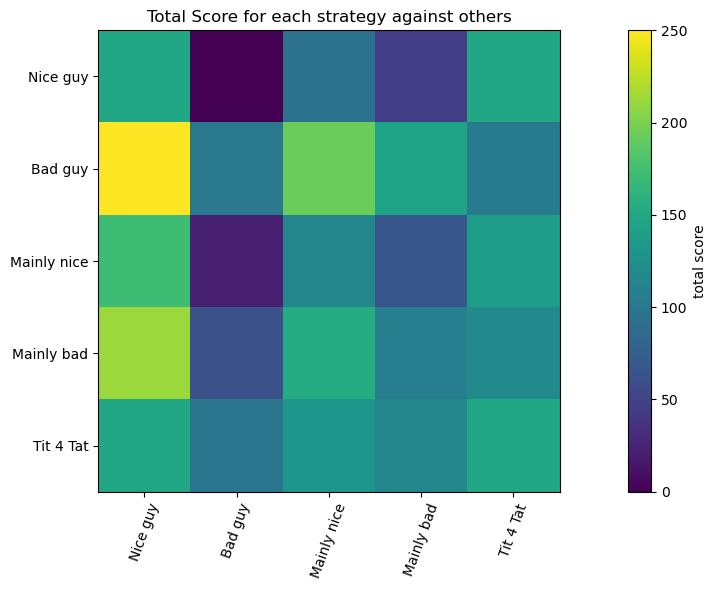

In [45]:
print('this table shows the total score of each strategy(in the y axis) against different strategies.')

# image size
plt.figure(figsize=(14, 6))

# Plot the tournament result as an image
plt.imshow(tournament, cmap='viridis')
plt.colorbar().set_label('total score')
plt.xticks(np.arange(len(people)), people, rotation=70)
plt.yticks(np.arange(len(people)), people)
plt.title('Total Score for each strategy against others')

plt.tight_layout()
plt.show()

### Let's hold a tournament!

* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme

first we just start with a situation that there are just one person for each strategy.

In [46]:
people_list = [Nice_guy, Bad_guy, Mainly_nice, Mainly_bad, tit_4_tat]
matchups = generate_matchups(people_list) 

tournament = np.array([])

for matchup in matchups:
    play = Game(M, matchup[0], matchup[1], 30)
    tournament = np.append(tournament, play.Play())

#### Raw result

In [47]:
for game in tournament:
    for key, val in game.items():
        print(key + ':', val)
    print('\n')

game_title: Nice_guy VS Bad_guy
actions_player_Nice_guy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rewards_player_Nice_guy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
total_reward_player_1: 0
actions_player_Bad_guy: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
rewards_player_Bad_guy: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
total_reward_player_2: 150


game_title: Nice_guy VS Mainly_nice
actions_player_Nice_guy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rewards_player_Nice_guy: [3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3]
total_reward_player_1: 63
actions_player_Mainly_nice: [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
rewards_player_Mainly_nice: [3, 3, 3, 5

#### Let's see the ranking

In [48]:
people = ['Nice_guy', 'Bad_guy', 'Mainly_nice', 'Mainly_bad', 'tit_4_tat']
ranking = {'Nice_guy': 0, 'Bad_guy': 0, 'Mainly_nice': 0, 'Mainly_bad': 0, 'tit_4_tat': 0}

for p in people:
    for game in tournament:
        try:
            ranking[p] += np.sum(game['rewards_player_' + p])
        except KeyError:
            continue

# Convert the ranking dictionary to a list of tuples for sorting
ranking_list = [(player, score) for player, score in ranking.items()]

# Sort the list based on scores in descending order
ranking_list.sort(key=lambda x: x[1], reverse=True)

# Print the ranking list
for rank, (player, score) in enumerate(ranking_list, start=1):
    print(f"Rank {rank}: {player} - Total Reward: {score}")

Rank 1: Bad_guy - Total Reward: 426
Rank 2: Mainly_bad - Total Reward: 351
Rank 3: tit_4_tat - Total Reward: 303
Rank 4: Mainly_nice - Total Reward: 253
Rank 5: Nice_guy - Total Reward: 183


As you see the bad guys get more scores, but what happense if we hold several tournaments and then rank them.

In [49]:
tournaments = np.array([])

for i in range(5):
    for matchup in matchups:
        play = Game(M, matchup[0], matchup[1], 30)
        tournaments = np.append(tournament, play.Play())

In [50]:
for p in people:
    for game in tournament:
        try:
            ranking[p] += np.sum(game['rewards_player_' + p])
        except KeyError:
            continue

# Convert the ranking dictionary to a list of tuples for sorting
ranking_list = [(player, score) for player, score in ranking.items()]

# Sort the list based on scores in descending order
ranking_list.sort(key=lambda x: x[1], reverse=True)

# Print the ranking list
for rank, (player, score) in enumerate(ranking_list, start=1):
    print(f"Rank {rank}: {player} - Total Reward: {score}")

Rank 1: Bad_guy - Total Reward: 852
Rank 2: Mainly_bad - Total Reward: 702
Rank 3: tit_4_tat - Total Reward: 606
Rank 4: Mainly_nice - Total Reward: 506
Rank 5: Nice_guy - Total Reward: 366


so in this kind of society every time the bad guy is the winner!

### Let's try another scenario
assume that we have 2 people for each strategy. in other words there are 10 participants.

In [51]:
# we need to creat our 5 new people
Nice_guy_2nd = Player({0:1, 1:1}, 1, 'Nice_guy_2nd')
Bad_guy_2nd = Player({0:0, 1:0}, 0, 'Bad_guy_2nd')
Mainly_nice_2nd = Player({0:0.7, 1:0.7}, 0.7, 'Mainly_nice_2nd') # k = 30
Mainly_bad_2nd = Player({0:0.3, 1:0.3}, 0.3, 'Mainly_bad_2nd') # k = 70
tit_4_tat_2nd = Player({0:1, 1:0}, 1, 'tit_4_tat_2nd')

In [52]:
people_list = [Nice_guy, Nice_guy_2nd, Bad_guy, Bad_guy_2nd, Mainly_nice, Mainly_nice_2nd, 
               Mainly_bad, Mainly_bad_2nd, tit_4_tat, tit_4_tat_2nd]

matchups = generate_matchups(people_list) 

tournament = np.array([])

for matchup in matchups:
    play = Game(M, matchup[0], matchup[1], 30)
    tournament = np.append(tournament, play.Play())

In [53]:
people = ['Nice_guy', 'Nice_guy_2nd', 'Bad_guy', 'Bad_guy_2nd', 'Mainly_nice', 'Mainly_nice_2nd',
          'Mainly_bad', 'Mainly_bad_2nd',  'tit_4_tat', 'tit_4_tat_2nd']
ranking = {'Nice_guy' : 0, 'Nice_guy_2nd' : 0, 'Bad_guy' : 0, 'Bad_guy_2nd' : 0, 'Mainly_nice' : 0, 'Mainly_nice_2nd' : 0,
          'Mainly_bad' : 0, 'Mainly_bad_2nd' : 0,  'tit_4_tat' : 0, 'tit_4_tat_2nd' : 0}

for p in people:
    for game in tournament:
        try:
            ranking[p] += np.sum(game['rewards_player_' + p])
        except KeyError:
            continue

# Convert the ranking dictionary to a list of tuples for sorting
ranking_list = [(player, score) for player, score in ranking.items()]

# Sort the list based on scores in descending order
ranking_list.sort(key=lambda x: x[1], reverse=True)

# Print the ranking list
for rank, (player, score) in enumerate(ranking_list, start=1):
    print(f"Rank {rank}: {player} - Total Reward: {score}")

Rank 1: Bad_guy - Total Reward: 912
Rank 2: Bad_guy_2nd - Total Reward: 912
Rank 3: Mainly_bad_2nd - Total Reward: 778
Rank 4: Mainly_bad - Total Reward: 768
Rank 5: tit_4_tat - Total Reward: 696
Rank 6: tit_4_tat_2nd - Total Reward: 696
Rank 7: Mainly_nice_2nd - Total Reward: 593
Rank 8: Mainly_nice - Total Reward: 583
Rank 9: Nice_guy - Total Reward: 456
Rank 10: Nice_guy_2nd - Total Reward: 456


# Implementing mutations and natural selection

To implement an evolutionary scheme, we will add a mutation mechanism to the players. In particular it can be noticed that each player can be described in terms of two "genes": the probability of cooperating when encountering cooperation (*rewarding* gene) and the probability of cooperating when encountering defection (*sucker* gene). Then, mutations can be understood in terms of small random fluctuations in the values that encode these genes, which ocurr with a given probabilty when a player generates an offspring. Additionally, natural selection can be implemented by eliminating the players with the lowest scores and replacing them with offspring from the best performing strategies.

In [336]:
# Let's define a function that can generate an offspring 
def get_new_generation(initial_player, mutation_prob, mutation_size):
    '''
    Params:
        initial_player : Player
            Instance of the Player class to be replicated.
        mutation_prob : float
            Must be between 0 and 1, probability of mutation
            for a given gene.
        mutation_size : float
            Size limit of the mutation of a given gene.
    Output:
        Returns a new Player instance, for which the strategy 
        is copied from the initial_player and each value is
        mutated an random amount in the uniform range 
        (-mutation_size, mutation_size) with probability 
        mutation_prob.
    '''
    # Get new strategy
    new_strategy = initial_player.strategy.copy()
    for k in new_strategy:
        # Check for mutations
        if np.random.uniform() < mutation_prob:
            # Draw mutation amount
            mutation_val = np.random.uniform(low=-mutation_size, 
                                             high=mutation_size)
            
            # Apply mutation within constraints
            new_strategy[k] = min(1, max(0, new_strategy[k] + mutation_val))
            
    # Define the new player
    new_player = Player(new_strategy, initial_action=initial_player.initial_action, 
                       name=initial_player.name)
    return new_player

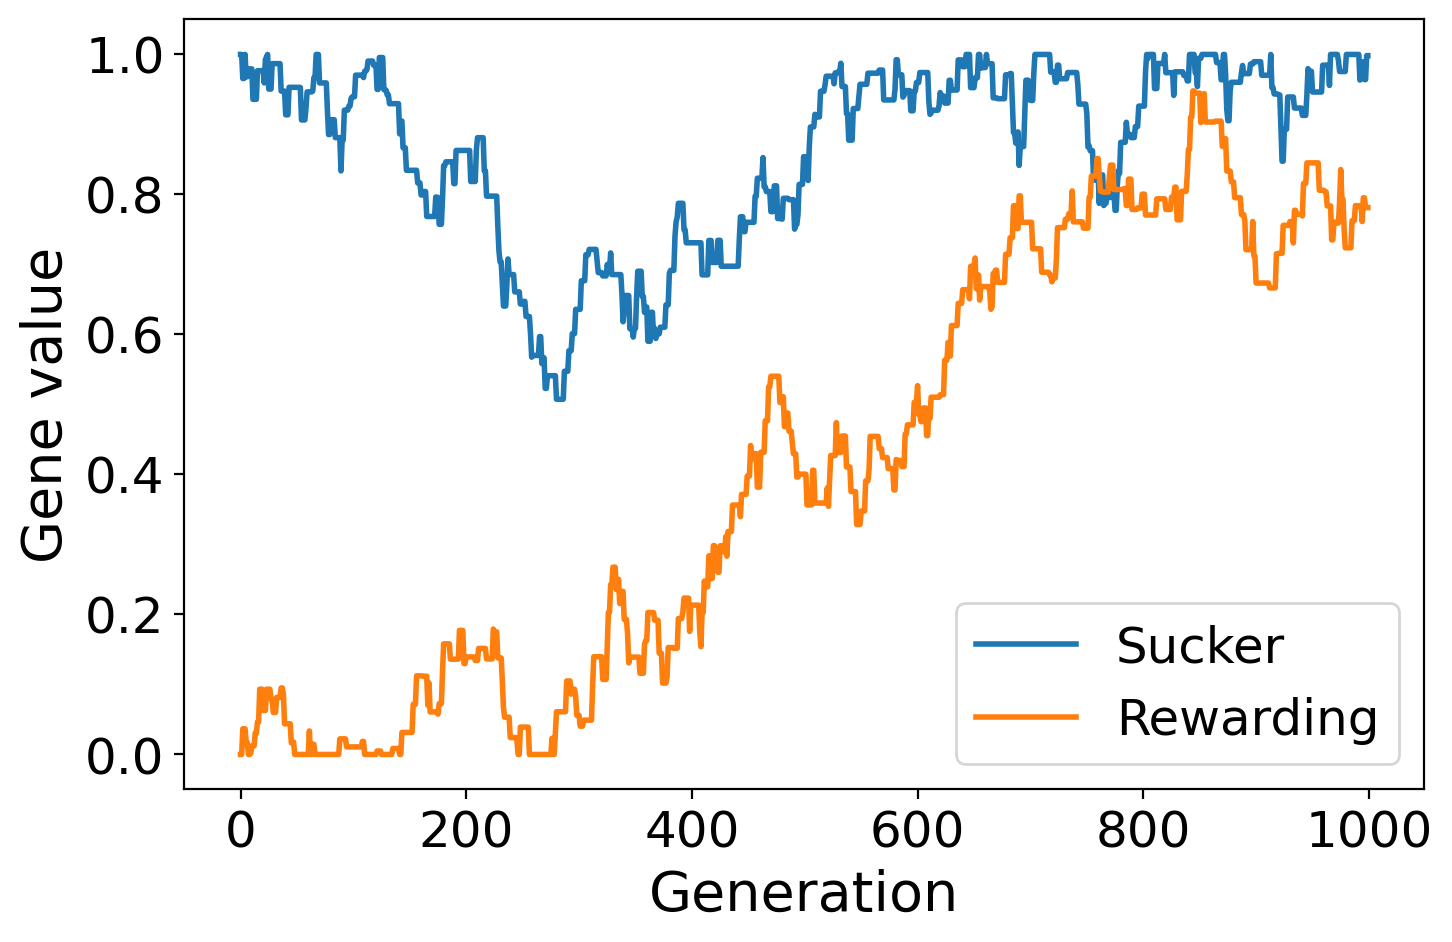

In [337]:
# Let's test our function by getting multiple generations
np.random.seed(42)
mutation_prob = 0.3
mutation_size = 0.05
player = tit_4_tat
strats = {0:[], 1:[]}
n_gens = 1000
for i in range(n_gens):
    player = get_new_generation(player, mutation_prob, mutation_size)
    strats[0].append(player.strategy[0])
    strats[1].append(player.strategy[1])

# Plot the results
FONTSIZE = 20
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=200)
plt.plot(range(n_gens), strats[0], label='Sucker', lw=2)
plt.plot(range(n_gens), strats[1], label='Rewarding', lw=2)
plt.xlabel('Generation', fontsize=FONTSIZE)
plt.ylabel('Gene value', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)
plt.legend(fontsize=FONTSIZE-2);

In [464]:
STRATEGE = {"No1": {0:1, 1:1}, "No2": {0:0, 1:0}, "No3":{0:0.7, 1:0.7}, "No4":{0:0.3, 1:0.3}, "No5":{0:1, 1:0}}


In [465]:
# eliminate last player and copy first player in player list
def update_list(people,ranking,i):
    #i is largest order of the people keep same stratage
    # Find the key with the minimum value
    min_guy = min(ranking, key=ranking.get)
    
    # Find the key with the maximum value
    max_guy = max(ranking, key=ranking.get)

    # Replace min player
    people.remove(min_guy)
    # Add order
    max_guy_add=max_guy[0:-4]
    if i+1<10:
        max_guy_add=str(max_guy_add+str("No0"+str(i+1)))
    else:
        max_guy_add=str(max_guy_add+str("No"+str(i+1)))
    
    
    # Add max player
    people=people.append(max_guy_add)
    


    return people,max_guy,max_guy_add




In [466]:
#chosen 80 player and their stratage_vector
playernb_list=[]
player_stratege={}
for i in range(80):
    if i+1<9:
        playernb_list.append("No0"+str(i+1))
        player_stratege["No0"+str(i+1)]=STRATEGE["No"+str(np.random.randint(1,6))]
    else:
        playernb_list.append("No"+str(i+1))
        player_stratege["No"+str(i+1)]=STRATEGE["No"+str(np.random.randint(1,6))]



In [467]:
#make players stratage
def player_list(playernb_list,player_stratege):
    player_list = []
    for i in playernb_list:
        i = Player(player_stratege[i], 1, i)
        player_list.append(i)
    return player_list



In [468]:
player_list = player_list(playernb_list,player_stratege)

matchups = generate_matchups(player_list) 

tournament = np.array([])

for matchup in matchups:
    play = Game(M, matchup[0], matchup[1], 30)
    tournament = np.append(tournament, play.Play())
print(tournament)

[{'game_title': 'No01 VS No02', 'actions_player_No01': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'rewards_player_No01': [3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'total_reward_player_1': 59, 'actions_player_No02': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'rewards_player_No02': [3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'total_reward_player_2': 64}
 {'game_title': 'No01 VS No03', 'actions_player_No01': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rewards_player_No01': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'total_reward_player_1': 90, 'actions_player_No03': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rewards_player_No03': [3, 3, 3, 3, 3, 3, 3,

In [469]:
#make a new Scoreboard
def rank(playernb_list):
    ranking = {}
    for i in playernb_list:
        ranking[i]=0
    return ranking


In [470]:
ranking = rank(playernb_list)
for p in playernb_list:
    for game in tournament:
        try:
            ranking[p] += np.sum(game['rewards_player_' + p])
        except KeyError:
            continue

# Convert the ranking dictionary to a list of tuples for sorting
ranking_list = [(player, score) for player, score in ranking.items()]

# Sort the list based on scores in descending order
ranking_list.sort(key=lambda x: x[1], reverse=True)

# Print the ranking list
for rank, (player, score) in enumerate(ranking_list, start=1):
        print(f"Rank {rank}: {player} - Total Reward: {score}")

Rank 1: No77 - Total Reward: 8134
Rank 2: No66 - Total Reward: 8098
Rank 3: No67 - Total Reward: 8098
Rank 4: No48 - Total Reward: 8044
Rank 5: No49 - Total Reward: 8044
Rank 6: No45 - Total Reward: 8038
Rank 7: No32 - Total Reward: 8002
Rank 8: No26 - Total Reward: 7990
Rank 9: No27 - Total Reward: 7990
Rank 10: No02 - Total Reward: 7936
Rank 11: No04 - Total Reward: 7936
Rank 12: No78 - Total Reward: 7026
Rank 13: No75 - Total Reward: 7002
Rank 14: No74 - Total Reward: 6992
Rank 15: No73 - Total Reward: 6982
Rank 16: No72 - Total Reward: 6972
Rank 17: No71 - Total Reward: 6962
Rank 18: No65 - Total Reward: 6938
Rank 19: No61 - Total Reward: 6907
Rank 20: No56 - Total Reward: 6884
Rank 21: No54 - Total Reward: 6873
Rank 22: No50 - Total Reward: 6848
Rank 23: No36 - Total Reward: 6762
Rank 24: No31 - Total Reward: 6733
Rank 25: No29 - Total Reward: 6719
Rank 26: No17 - Total Reward: 6638
Rank 27: No08 - Total Reward: 6605
Rank 28: No07 - Total Reward: 6595
Rank 29: No06 - Total Reward:

In [471]:
#ith times replace the lowest player 
def update_list(playernb_list,player_stratege,ranking,i):
    # i is the times
    # Find the key with the minimum value
    losser = min(ranking, key=ranking.get)

    # Find the key with the maximum value
    winner = max(ranking, key=ranking.get)

    # Replace losser_name
    playernb_list.remove(losser)
    # Add new player
    playernb_list.append("No"+str(i+80))
    # Add new stratage
    player_stratege["No"+str(i+80)]=player_stratege[winner]
    # Replace losser_stratege
    del player_stratege[losser]
    return new_func(playernb_list, player_stratege)

def new_func(playernb_list, player_stratege):
    return playernb_list,player_stratege
    





In [472]:
playernb_list,player_stratege = update_list(playernb_list,player_stratege,ranking,1)


In [473]:
print(playernb_list)

['No01', 'No02', 'No03', 'No04', 'No06', 'No07', 'No08', 'No9', 'No10', 'No11', 'No12', 'No13', 'No14', 'No15', 'No16', 'No17', 'No18', 'No19', 'No20', 'No21', 'No22', 'No23', 'No24', 'No25', 'No26', 'No27', 'No28', 'No29', 'No30', 'No31', 'No32', 'No33', 'No34', 'No35', 'No36', 'No37', 'No38', 'No39', 'No40', 'No41', 'No42', 'No43', 'No44', 'No45', 'No46', 'No47', 'No48', 'No49', 'No50', 'No51', 'No52', 'No53', 'No54', 'No55', 'No56', 'No57', 'No58', 'No59', 'No60', 'No61', 'No62', 'No63', 'No64', 'No65', 'No66', 'No67', 'No68', 'No69', 'No70', 'No71', 'No72', 'No73', 'No74', 'No75', 'No76', 'No77', 'No78', 'No79', 'No80', 'No81']
